In [1]:
import pandas as pd
import plotly.express as px
import plotly.io as pio
import numpy as np
from matplotlib.pyplot import plot, savefig
import warnings
warnings.filterwarnings('ignore')


---

# Analiza danych - wykresy umieszczone na plakacie

Notebook zawiera koneiczne funkcje oraz wykresy umieszczone później na plakacie.

## Funkcje 

In [2]:
def stance_analysis(file:str,
                    name_save:str='figure', name_author:str='polityk', 
                    if_sejm:bool=False
                    ):
        
    data = pd.read_pickle(f'{file}')
    data['stance'] = data['stance'].replace({'NEITHER': 0,
                                    'FAVOR': 1,
                                    'AGAINST': -1,
                                    })
    
    if 'author' not in data.columns:
        data.rename(columns={'username': 'author'}, inplace=True)

    if if_sejm:
        data['author'] = data['author'].apply(lambda x: x.title())

    # średnia z dnia dla stance 
    data['date'] = data['date'].apply(pd.to_datetime).dt.date
    df_mean_stance = data.groupby(['date', 'topic_name', 'author'])['stance'].mean().reset_index(name='mean_stance') # jeżeli w dniu więcej jak jedna zmiana to wtedy ma wpływ 
    df_mean_stance.sort_values(['author', 'topic_name', 'date'], ascending=True, inplace=True) 
    df_mean_stance.reset_index(drop=True, inplace=True)

    # czy w danym temacie u danego autora nastąpiłą zmiana stance z -1 na 1 lub na odwrót?
    df_mean_stance['stance_changed_author_topic'] = df_mean_stance.groupby(by=['author', 'topic_name'])['mean_stance'].transform(lambda x: x.max() > 0 and x.min() < 0)


    # --------------------------------------------------------------------------------------------------------
    # obliczenie dni pomiędzy zminaą mean_stance z -1 na 1 lub na odwród dla danego autora w danym temacie + dodanie kolumny stance_change, wpisujemy True jeżeli taka zmiana nastąpiła 
    
    df_stance_mean_changed = df_mean_stance[df_mean_stance['stance_changed_author_topic'] == True] #wsystkie tematy z autorami gdzie autor zmienił stance (zmiana stance_mean)
    df_stance_mean_changed.reset_index(drop=True, inplace=True)
    df_stance_mean_changed['count_days'] = pd.NA
    authors = df_stance_mean_changed['author'].unique()

    for author in authors:
        counter = 0
        for i in df_stance_mean_changed[df_stance_mean_changed['author'] == author].index:
            if counter == 0:
                counter += 1
                n = i 
            else:
                if df_stance_mean_changed.iloc[i]['topic_name'] == df_stance_mean_changed.iloc[i-1]['topic_name']:
                    if df_stance_mean_changed.iloc[i]['mean_stance'] * df_stance_mean_changed.iloc[n]['mean_stance'] < 0: 
                        df_stance_mean_changed.at[i, 'count_days'] = (df_stance_mean_changed.iloc[i]['date'] - df_stance_mean_changed.iloc[n]['date']).days
                        df_stance_mean_changed.at[i, 'stance_changed'] = True
                        n = i
                    else:
                        if df_stance_mean_changed.iloc[i]['mean_stance'] != 0 and df_stance_mean_changed.iloc[n]['mean_stance']==0:
                            n=i
                        df_stance_mean_changed.at[i, 'stance_changed'] = False
                else:
                    n = i
    
    df_mean_stance = pd.merge(df_mean_stance, df_stance_mean_changed[["date", "topic_name", "author", "stance_changed", "count_days"]], on=["date", "topic_name", "author"], how='left')
    df_mean_stance['stance_changed'] = df_mean_stance['stance_changed'].fillna(False)


    # --------------------------------------------------------------------------------------------------------
    # wyliczenie procenta wypowiedzi według tematów, gdzie nastąpiła zmiana nastawienia 

    print('\n\nW których tematach najczęściej zmieniano zdanie?\n')
    df_mean_stance['count_change'] = df_mean_stance[df_mean_stance['stance_changed'] == True].groupby(by=['topic_name'])['topic_name'].transform('count') # zlicza liczbę tweetów w danym temacie gdzie wystąpiła zmiana zdania 
    df_mean_stance['count_topic'] = df_mean_stance.groupby(by=['topic_name'])['stance_changed'].transform('count') # zlicza liczbę wszytkich tweetów w danym temacie

    
    df_mean_stance['percent_stance_change'] = df_mean_stance['count_change'] / df_mean_stance['count_topic']
    df_mean_stance['percent_stance_change'] *= 100
    

    df_final = df_mean_stance[df_mean_stance['stance_changed']==True].drop_duplicates(subset=['topic_name']).sort_values('percent_stance_change', ascending=False).reset_index(drop=True)

    df_final_10 = df_final.sort_values('percent_stance_change', ascending=False).head(10)
    color_discrete_sequence = ['#414fa0']*len(df_final)
    
    fig = px.bar(df_final_10, x='percent_stance_change', y='topic_name', 
                 labels={'percent_stance_change': 'Procent wypowiedzi, gdzie nastąpiła zmiana nastawienia [%]', 'topic_name': 'Temat'}, color_discrete_sequence=color_discrete_sequence,
                 width=850, height=350)
    
    fig.update_layout({
    'plot_bgcolor': 'rgba(0, 0, 0, 0)',
    'paper_bgcolor': 'rgba(0, 0, 0, 0)'
    })

    # zapis
    pio.write_image(fig, f"{name_save}_topic_stance_percent.svg")
    fig.show()

    # ------------------------------------------------------------------------------------------------------------
    # zliczenie dla każdego autora w ilu wypowiedziach zmienił nastawienie 
    
    print('\n\nKto najczęściej zmienia swoje poglądy?\n')
    df_mean_stance['count_change_author'] = df_mean_stance[df_mean_stance['stance_changed'] == True].groupby(by=['author'])['topic_name'].transform('count') # zlicza liczbę tweetów w danym temacie gdzie wystąpiła zmiana zdania 
    df_final_author = df_mean_stance[df_mean_stance['stance_changed']==True].drop_duplicates(subset=['author']).sort_values('count_change_author', ascending=False).reset_index(drop=True)

    display(df_final_author[['author', 'count_change_author']])

    df_final_10_author = df_final_author.head(10)
    color_discrete_sequence = ['#414fa0']*len(df_final_10_author)
    
    fig = px.bar(df_final_10_author, x='count_change_author', y='author', 
                 labels={'count_change_author': 'Liczba wypowiedzi, gdzie nastąpiła zmiana zdania', 'author': name_author}, color_discrete_sequence=color_discrete_sequence,
                 width=750, height=350)
    fig.update_layout({
    'plot_bgcolor': 'rgba(0, 0, 0, 0)',
    'paper_bgcolor': 'rgba(0, 0, 0, 0)'
    })

    # zapis
    pio.write_image(fig, f"{name_save}_author_change_stance_count.svg")
    fig.show()

    # -----------------------------------------------------------------------------------
    # obliczanie średniej liczby dni dla danego autora w danym temacie, następnie obliczenie średnich dla danego tematu po średnich autorów
    print('\n\nIle czasu średnio potrzeba na zmianę poglądu?\n')
    
    days_per_author_topic = df_mean_stance.dropna(subset=['count_days'])
    days_per_author_topic = days_per_author_topic.groupby(['author', 'topic_name'])['count_days'].mean().reset_index()
    days_per_author_topic = days_per_author_topic.rename(columns={'count_days': 'mean_days_author_topic'})

    days_per_topic = days_per_author_topic.groupby(['topic_name'])['mean_days_author_topic'].mean().reset_index()
    days_per_topic = days_per_topic.rename(columns={'mean_days_author_topic': 'mean_days_topic'})

    days_per_topic = days_per_topic.sort_values('mean_days_topic', ascending=False)
    days_per_topic.dropna(subset=['mean_days_topic'], inplace=True)
    days_per_topic_10 = days_per_topic.head(10)
    days_per_topic_10 = days_per_topic_10.sort_values('mean_days_topic', ascending=True)
    display(days_per_topic_10)
    fig = px.bar(days_per_topic_10, y='topic_name', x='mean_days_topic', orientation='h',
                color_discrete_sequence=color_discrete_sequence,
                labels={'topic_name': 'Temat', 'mean_days_topic': 'Średnia liczba dni'}, width=750, height=350)
    fig.update_layout({
    'plot_bgcolor': 'rgba(0, 0, 0, 0)',
    'paper_bgcolor': 'rgba(0, 0, 0, 0)'
    })
    pio.write_image(fig, f"{name_save}_mean_days_topic.svg")
    fig.show()

    # print(f"Potrzeba średnio {np.mean(df_mean_stance['count_days'].dropna().to_list())} dni na zmianę poglądów - bez podziałów")
    # print(f"Potrzeba średnio {np.mean(days_per_author_topic['mean_days_author_topic'].to_list())} dni na zmianę poglądów - podział na tematy")
    print(f"Potrzeba średnio {np.mean(days_per_topic['mean_days_topic'].dropna().to_list())} dni na zmianę poglądu (średnia  z autorami + temat, a następnie średnia po temacie")

    return df_mean_stance
    


In [3]:
def topic_analysis(data:pd.DataFrame,
                   name_save:str = 'figure', author:str='Mówca'):
    
    if 'author' not in data.columns:
        data.rename(columns={'username': 'author'}, inplace=True)

    data_topic_grouped = data.groupby(['author', 'topic_name'])['date'].count().reset_index(name='count').sort_values('count', ascending=False) 
    
    data_topics_per_author = data.drop_duplicates(subset=['author', 'topic_name'])
    data_topics_per_author = data_topics_per_author.groupby(['author'])['topic_name'].count().reset_index(name='count_topics').sort_values('count_topics', ascending=False) 
    top_active_authors = data_topics_per_author.head(10)
    
    print('Kto porusza najwięcej tematów?\n')
    display(top_active_authors)
    
    color_discrete_sequence = ['#414fa0']*len(data)
    fig = px.bar(top_active_authors, x='author', y='count_topics', 
                labels={'author': author, 'count_topics': 'Liczba poruszonych tematów'}, color_discrete_sequence=color_discrete_sequence,
                width=500, height=350)
    
    fig.update_layout({
    'plot_bgcolor': 'rgba(0, 0, 0, 0)',
    'paper_bgcolor': 'rgba(0, 0, 0, 0)'
    })
    fig.show()

    # zapis
    pio.write_image(fig, f"{name_save}_topic_analysis.svg")
    
    return data_topic_grouped, data_topics_per_author, top_active_authors

___

## Twitter

In [4]:
data_tweets = stance_analysis('../dane/done/tweets_with_stancev2.pkl', name_save='tweets', name_author='Nazwa użytkownika')
_ = topic_analysis(data_tweets, name_save='twitter', author='Nazwa użytkownika')



W których tematach najczęściej zmieniano zdanie?





Kto najczęściej zmienia swoje poglądy?



,author,count_change_author
0,styszka,25.0
1,partiarazem,20.0
2,wojciech_krol,16.0
3,beatamk,16.0
4,pawelbejda,15.0
...,...,...
57,pikus_pol,1.0
58,l_dobrzynski,1.0
59,m_bochenek93,1.0
60,marcinwarchol,1.0




Ile czasu średnio potrzeba na zmianę poglądu?



,topic_name,mean_days_topic
18,publiczna opieka zdrowotna,185.5
17,programy mieszkaniowe,189.571429
3,bezpieczeństwo Polaków,196.638889
4,bezrobocie to wina rządu,208.8
6,działania wojskowe,220.916667
20,sądownictwo,274.271053
14,podatki,314.142857
0,NSZZ Solidarność,441.0
1,Unia Europejska,816.0
22,wsparcie osób niepełnosprawnych,951.0


Potrzeba średnio 215.85766635501923 dni na zmianę poglądu (średnia  z autorami + temat, a następnie średnia po temacie
Kto porusza najwięcej tematów?



,author,count_topics
45,m_gdula,33
64,partiarazem,33
3,agnieszkahana,30
18,donaldtusk,28
82,szymon_holownia,28
80,styszka,26
91,wojciech_krol,26
83,trzaskowski_,25
10,beatamk,25
87,waldydzikowski,25


## Sejm

In [5]:
data_sejm  = stance_analysis('../dane/done/sejm_stance_v3.pkl', name_save='sejm', name_author='Mówca', if_sejm=True)
_ = topic_analysis(data_sejm, name_save='sejm', author='Mówca')



W których tematach najczęściej zmieniano zdanie?





Kto najczęściej zmienia swoje poglądy?



,author,count_change_author
0,Krystyna Skowrońska,43.0
1,Jan Rulewski,30.0
2,Krystyna Szumilas,28.0
3,Paulina Hennig-Kloska,27.0
4,Mieczysław Augustyn,25.0
...,...,...
675,Józef Zych,1.0
676,Józef Racki,1.0
677,Julian Srebrny,1.0
678,Joanna Strzelec-Łobodzińska,1.0




Ile czasu średnio potrzeba na zmianę poglądu?



,topic_name,mean_days_topic
5,dofinansowania na mieszkania,934.041667
27,prawa kobiet,941.208333
18,komunizm,1015.0
23,ochrona prawna mniejszości narodowych,1050.0
33,rozwój rybołóstwa,1062.7
1,akcyza na alkohol,1307.625
3,bezrobocie,1327.916667
16,inwestowanie w poprawę infrastruktury drogowej,1447.0
24,paliwo,1459.1
13,hazard,1772.0


Potrzeba średnio 801.7063981772163 dni na zmianę poglądu (średnia  z autorami + temat, a następnie średnia po temacie
Kto porusza najwięcej tematów?



,author,count_topics
2067,Mirosław Suchoń,41
1967,Małgorzata Pępek,40
249,Andrzej Szlachta,39
1074,Jan Rulewski,38
496,Bogdan Borusewicz,38
2615,Tadeusz Tomaszewski,36
887,Henryk Siedlaczek,36
1847,Maria Jackowski,35
855,Grzegorz Wojciechowski,34
1313,Józef Rojek,33


## Analiza dla wybranych osób

### Porównanie jak wypowiadał się w Sejmi i na Twitterze Wojciech Król w temacie 'media publiczne'

In [6]:
def plot_stance(df, topic, name_save, auhor_label='Mówca'):
    df = df.sort_values(['date'])
    color_discrete_sequence = ['#414fa0']*len(df)
    fig = px.line(data_frame = df[df['topic_name'] == topic],
            x = 'date',
            y = 'mean_stance',
            color = 'author',
            labels = {'date': 'Data', 'stance': 'Nastawienie', 'author':auhor_label},
            markers=3, color_discrete_sequence=color_discrete_sequence,
            width=800, height=400).update_traces(line={'width':2})
    fig.update_layout(
    legend=dict(
        x=0.1, 
        y=0.9, 
        traceorder='reversed'
    ))
    
    fig.update_layout({
    'plot_bgcolor': 'rgba(240, 241, 248, 0.7)',
    'paper_bgcolor': 'rgba(0, 0, 0, 0)'
    })

    fig.update_layout(
    xaxis=dict(gridcolor='lightgray', tickfont=dict(size=13) ), 
    yaxis=dict(gridcolor='lightgray', tickfont=dict(size=13) ), 
    )

    fig.show()
    pio.write_image(fig, f"{name_save}_stance_change_in_time.svg")    

In [7]:
print("\n\nWykres zminay nastawienia w czasie dla tematu 'media publiczne' na Twitterze")
df_wk_tweets = data_tweets[data_tweets['author']=='wojciech_krol']   
plot_stance(df_wk_tweets, f'media publiczne', 'tweets', 'Nazwa użytkownika')

print("\n\nWykres zminay nastawienia w czasie dla tematu 'media publiczne' w Sejmie")
df_wk_sejm = data_sejm[data_sejm['author']=='Wojciech Król']   
plot_stance(df_wk_sejm, f'media publiczne', 'sejm', 'Mówca')



Wykres zminay nastawienia w czasie dla tematu 'media publiczne' na Twitterze




Wykres zminay nastawienia w czasie dla tematu 'media publiczne' w Sejmie


### Kto najczęściej zmienia swoje poglądy? - analiza dla 'Krystyna Skowrońska' (sejm) i 'styszka' (twitter)

In [8]:
print('styszka')
df_st_tweets = data_tweets[data_tweets['author']=='styszka'][data_tweets['stance_changed_author_topic']==True]
df_st_tweets = df_st_tweets.groupby('topic_name')['count_days'].mean().reset_index()
display(df_st_tweets)
print(f'średnia liczba dni na potrzebna na zmianę zdania {np.mean(df_st_tweets["count_days"].to_list())}')

styszka


,topic_name,count_days
0,aborcja,59.5
1,imigranci,167.666667
2,inflacja,43.0
3,konfederacja,23.181818
4,media publiczne,50.0
5,podatki,1074.0
6,programy mieszkaniowe,44.0
7,sądownictwo,196.333333


średnia liczba dni na potrzebna na zmianę zdania 207.21022727272725


In [9]:
print('Krystyna Skowrońska')
df_ks_sejm = data_sejm[data_sejm['author']=='Krystyna Skowrońska'][data_sejm['stance_changed_author_topic']==True]
df_ks_sejm = df_ks_sejm.groupby('topic_name')['count_days'].mean().reset_index()
display(df_ks_sejm)
print(f'średnia liczba dni na potrzebna na zmianę zdania {np.mean(df_ks_sejm["count_days"].to_list())}')

Krystyna Skowrońska


,topic_name,count_days
0,akcyza na wyroboy tytoniowe,126.0
1,dofinansowania na mieszkania,913.5
2,emerytura,4786.0
3,finansowanie szkolnictwa,1365.25
4,media publiczne,661.375
5,podatki,1876.5
6,publiczna opieka zdrowotna,306.111111
7,wsparcie rolników,1100.75
8,węgiel,240.666667


średnia liczba dni na potrzebna na zmianę zdania 1264.016975308642


## Krótka analiza - wordcloud i dodatkowe dane do plakatu 

In [2]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import random

In [4]:
sejm = pd.read_csv("../data/sejm_stance_v3.csv")
sejm

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,date,author,text_all,place,TextBlob_Subjectivity,TextBlob_Polarity,sentiment_herbert,...,is_outlier,detected_topic,topic_name,stance,stance_score,diff_max_min_stance,stance_changed,last_two_letters,name,topic_name_corrected
0,0,0,472.0,2019-11-19,dariusz klimczak,pani marszałek! wysoka izbo! panie premierze! ...,sejm,0.0000,0.0,1,...,False,2,szczepienia,NEITHER,0.700330,0,False,"['dariusz', 'klimczak']",dariusz klimczak,szczepienia
1,1,1,648.0,2019-11-19,cezary grabarczyk,pani marszałek! wysoka izbo! panie premierze! ...,sejm,0.0000,0.0,-1,...,False,11,inwestowanie w poprawę infrastruktury drogowej,FAVOR,0.638683,2,True,"['cezary', 'grabarczyk']",cezary grabarczyk,inwestowanie w poprawę infrastruktury drogowej
2,2,2,900.0,2019-11-19,karolina pawliczak,pani marszałek! wysoka izbo! odniosę się do ex...,sejm,0.0000,0.0,1,...,False,11,inwestowanie w poprawę infrastruktury drogowej,FAVOR,0.651762,1,False,"['karolina', 'pawliczak']",karolina pawliczak,inwestowanie w poprawę infrastruktury drogowej
3,3,3,979.0,2019-11-19,katarzyna kretkowska,pani marszałek! wysoki sejmie! panie premierze...,sejm,0.0000,0.0,0,...,False,11,inwestowanie w poprawę infrastruktury drogowej,NEITHER,0.627764,0,False,"['katarzyna', 'kretkowska']",katarzyna kretkowska,inwestowanie w poprawę infrastruktury drogowej
4,4,4,1780.0,2019-11-21,stanisław szwed,pani marszałek! wysoka izbo! państwo posłowie ...,sejm,0.1250,0.0,1,...,False,2,prawa dziecka,NEITHER,0.679927,2,True,"['stanisław', 'szwed']",stanisław szwed,prawa dziecka
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66737,68069,68069,NaN,2020-02-05,wojciech konieczny,"dobrze. tak że moje pytanie jest takie, czy is...",senat,0.0000,0.0,1,...,True,1,publiczna opieka zdrowotna,FAVOR,0.452765,0,False,"['wojciech', 'konieczny']",wojciech konieczny,publiczna opieka zdrowotna
66738,68070,68070,NaN,2020-02-05,wojciech konieczny,dziękuję bardzo. proszę państwa! szanowni sena...,senat,0.0625,0.0,1,...,True,1,publiczna opieka zdrowotna,FAVOR,0.532426,0,False,"['wojciech', 'konieczny']",wojciech konieczny,publiczna opieka zdrowotna
66739,68071,68071,NaN,2020-02-06,krzysztof kwiatkowski,szanowni państwo! ja namawiałbym do rozważenia...,senat,0.0000,0.0,1,...,True,5,inwestowanie w poprawę infrastruktury drogowej,NEITHER,0.567528,0,False,"['krzysztof', 'kwiatkowski']",krzysztof kwiatkowski,inwestowanie w poprawę infrastruktury drogowej
66740,68072,68072,NaN,2020-02-06,jerzy czerwiński,pani marszałek! wysoka izbo! tak jak już pani ...,senat,0.0000,0.0,0,...,True,5,inwestowanie w poprawę infrastruktury drogowej,NEITHER,0.470548,1,False,"['jerzy', 'czerwiński']",jerzy czerwiński,inwestowanie w poprawę infrastruktury drogowej


In [4]:
len(sejm['author'].unique())

2989

In [5]:
sejm['date'].min()

'2007-11-05'

In [6]:
sejm_suchon = sejm[sejm['author'] == 'mirosław suchoń']
sejm_suchon

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,date,author,text_all,place,TextBlob_Subjectivity,TextBlob_Polarity,sentiment_herbert,...,is_outlier,detected_topic,topic_name,stance,stance_score,diff_max_min_stance,stance_changed,last_two_letters,name,topic_name_corrected
106,106,106,17073.0,2020-05-28,mirosław suchoń,bardzo dziękuję. szanowna pani marszałek! pano...,sejm,0.100,-0.125,-1,...,False,11,inwestowanie w poprawę infrastruktury drogowej,FAVOR,0.609101,2,True,"['mirosław', 'suchoń']",mirosław suchoń,inwestowanie w poprawę infrastruktury drogowej
115,115,115,17147.0,2020-05-28,mirosław suchoń,bardzo dziękuję. pani marszałek! wysoka izbo! ...,sejm,0.125,0.000,-1,...,False,41,zaostrzenie przepisów dotyczących pedofilii,FAVOR,0.646401,0,False,"['mirosław', 'suchoń']",mirosław suchoń,zaostrzenie przepisów dotyczących pedofilii
208,208,208,19766.0,2020-07-24,mirosław suchoń,bardzo dziękuję. szanowna pani marszałek! pani...,sejm,0.000,0.000,0,...,False,2,prawa dziecka,NEITHER,0.588594,1,False,"['mirosław', 'suchoń']",mirosław suchoń,prawa dziecka
285,287,287,21826.0,2020-10-27,mirosław suchoń,bardzo dziękuję. pani marszałek! panie ministr...,sejm,0.000,0.000,1,...,False,18,prawa kobiet,FAVOR,0.446343,0,False,"['mirosław', 'suchoń']",mirosław suchoń,prawa kobiet
405,407,407,26606.0,2021-02-24,mirosław suchoń,uprzejmie dziękuję. panie marszałku! panie min...,sejm,0.000,0.000,1,...,False,11,inwestowanie w poprawę infrastruktury drogowej,FAVOR,0.417266,2,True,"['mirosław', 'suchoń']",mirosław suchoń,inwestowanie w poprawę infrastruktury drogowej
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62981,64313,64313,NaN,2021-04-14,mirosław suchoń,"przypomnę, że na przykład w 2013 r. inflacja w...",sejm,0.200,-0.100,0,...,True,9,inflacja,AGAINST,0.689160,0,False,"['mirosław', 'suchoń']",mirosław suchoń,inflacja
62982,64314,64314,NaN,2021-04-14,mirosław suchoń,"dziękuję, panie przewodniczący. ufając, że jed...",sejm,0.400,-0.200,1,...,True,9,inflacja,AGAINST,0.561733,0,False,"['mirosław', 'suchoń']",mirosław suchoń,inflacja
62990,64322,64322,NaN,2023-05-09,mirosław suchoń,"bardzo dziękuję, panie przewodniczący. dwie kw...",sejm,0.200,-0.100,0,...,True,2,wsparcie rolników,FAVOR,0.456523,1,False,"['mirosław', 'suchoń']",mirosław suchoń,wsparcie rolników
63167,64499,64499,NaN,2021-12-01,mirosław suchoń,ostatnia minuta. dziękuję bardzo za przypomnie...,sejm,0.000,0.000,0,...,True,8,wsparcie dla wojska,NEITHER,0.545595,2,True,"['mirosław', 'suchoń']",mirosław suchoń,wsparcie dla wojska


In [7]:
sejm_suchon['topic_name'].value_counts().sum()

350

In [8]:
tweets = pd.read_csv("../data/tweets_with_stancev2.csv")

In [9]:
tweets

,Unnamed: 0,tweet_id,username,is_retweet,is_pinned,date,text,replies,retweets,likes,...,SYM,INTJ,topic,TextBlob_Subjectivity,TextBlob_Polarity,sentiment_herbert,detected_topic,topic_name,stance,stance_score
0,0,1716753316548432358,pomaska,True,False,2023-10-24 09:47:00,transmisja konferencji prasowej opozycji w tvp...,549.0,388.0,3479.0,...,0.0,0.0,5,0.0,0.0,0,13,media publiczne,NEITHER,0.480091
1,1,1711644403553444282,barbaraanowacka,True,False,2023-10-10 07:26:00,brawo pomaska - skutecznie punktuje kłamstwa p...,21.0,102.0,421.0,...,0.0,0.0,4,0.0,0.0,1,13,media publiczne,NEITHER,0.619147
2,2,1713913388227543294,pomaska,False,False,2023-10-16 13:42:00,2 miliardy dla chorych na raka zamiast na szcz...,192.0,232.0,1856.0,...,0.0,0.0,5,0.0,0.0,-1,5,szczepienia,NEITHER,0.587503
3,3,1713875840272830587,pomaska,False,False,2023-10-16 11:13:00,a co tam w cbos_info słychać cisza jakaś,40.0,27.0,398.0,...,0.0,0.0,5,0.0,0.0,-1,13,media publiczne,NEITHER,0.788530
4,4,1711429741243187584,pomaska,False,False,2023-10-09 17:13:00,pracownicy tvp chcieli ośmieszyć donaldtusk oś...,90.0,101.0,587.0,...,0.0,0.0,5,0.0,0.0,-1,13,media publiczne,AGAINST,0.432539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8338,8338,1714609872484909525,pikus_pol,False,False,2023-10-18 11:50:00,kandydaci ko na stanowisko ministra on😮😮😮😮 jpr...,98.0,61.0,224.0,...,0.0,0.0,5,0.0,0.0,0,6,sądownictwo,NEITHER,0.982022
8339,8339,1714579613567914002,niezaleznapl,False,False,2023-10-18 09:50:00,„przed pis są bardzo ważne kolejne wyzwania” m...,NaN,8.0,21.0,...,0.0,0.0,2,0.0,0.0,0,3,kampania wyborcza,FAVOR,0.494366
8340,8340,1714575432136225196,jciesz,False,False,2023-10-18 09:33:00,warto przypomnieć kłamstwa donaldtusk który tw...,1.0,5.0,11.0,...,1.0,0.0,5,0.0,0.0,0,3,kampania wyborcza,AGAINST,0.538916
8341,8341,1714572399088152817,sobonartur,False,False,2023-10-18 09:21:00,jaki wnoszę wkład na lubelską listę pisorgpl s...,23.0,3.0,30.0,...,4.0,0.0,5,0.0,0.0,1,3,kampania wyborcza,NEITHER,0.476788


In [10]:
tweets['topic_name'].unique()

array(['media publiczne', 'szczepienia', 'likwidacja terenów zielonych',
       'imigranci', 'publiczna opieka zdrowotna', 'programy mieszkaniowe',
       'rozwój gospodarki morskiej', 'trzecia droga',
       'bezpieczeństwo Polaków', 'dbanie o środowisko/klimat',
       'działania wojskowe', 'Unia Europejska', 'wsparcie dla Ukrainy',
       'NSZZ Solidarność', 'bezrobocie to wina rządu', 'podatki',
       'inflacja', 'kobiety na wybory/kobiety w rządzie', 'aborcja',
       'prawa kobiet', 'reformy energetyczne / odnawialne źródła energii',
       'węgiel', 'podwyżki dla nauczycieli',
       'zwiększenie kar dla pedofili', 'pamięć narodowa',
       'polityka Koalicji Obywatelskiej', 'lewica',
       'wsparcie polskich przedsiębiorców', 'krótsze godziny pracy',
       'rozwój transportu publicznego', 'kampania wyborcza',
       'sądownictwo', 'konflikt Izrael-Palestyna', 'prawa zwierząt',
       'konfederacja', 'wsparcie rolników', 'inwestycje lokalne',
       'kościół', 'stosunki z Ros

In [11]:
df_filtered = tweets[~tweets['topic_name'].str.contains('kampania wyborcza')]

In [12]:
df_filtered

,Unnamed: 0,tweet_id,username,is_retweet,is_pinned,date,text,replies,retweets,likes,...,SYM,INTJ,topic,TextBlob_Subjectivity,TextBlob_Polarity,sentiment_herbert,detected_topic,topic_name,stance,stance_score
0,0,1716753316548432358,pomaska,True,False,2023-10-24 09:47:00,transmisja konferencji prasowej opozycji w tvp...,549.0,388.0,3479.0,...,0.0,0.0,5,0.0,0.0,0,13,media publiczne,NEITHER,0.480091
1,1,1711644403553444282,barbaraanowacka,True,False,2023-10-10 07:26:00,brawo pomaska - skutecznie punktuje kłamstwa p...,21.0,102.0,421.0,...,0.0,0.0,4,0.0,0.0,1,13,media publiczne,NEITHER,0.619147
2,2,1713913388227543294,pomaska,False,False,2023-10-16 13:42:00,2 miliardy dla chorych na raka zamiast na szcz...,192.0,232.0,1856.0,...,0.0,0.0,5,0.0,0.0,-1,5,szczepienia,NEITHER,0.587503
3,3,1713875840272830587,pomaska,False,False,2023-10-16 11:13:00,a co tam w cbos_info słychać cisza jakaś,40.0,27.0,398.0,...,0.0,0.0,5,0.0,0.0,-1,13,media publiczne,NEITHER,0.788530
4,4,1711429741243187584,pomaska,False,False,2023-10-09 17:13:00,pracownicy tvp chcieli ośmieszyć donaldtusk oś...,90.0,101.0,587.0,...,0.0,0.0,5,0.0,0.0,-1,13,media publiczne,AGAINST,0.432539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8331,8331,1714920035653734411,kr_szumilas,False,False,2023-10-19 08:22:00,widzieliście już gdzieś świeżo docieplone budy...,33.0,87.0,386.0,...,0.0,0.0,5,0.0,0.0,0,6,sądownictwo,NEITHER,0.987076
8332,8332,1714910512738148599,niezaleznapl,False,False,2023-10-19 07:45:00,według posła po: pakt migracyjny zapewni więks...,20.0,54.0,88.0,...,0.0,0.0,5,0.0,0.0,0,0,imigranci,FAVOR,0.574745
8335,8335,1714740675546124337,niezaleznapl,False,False,2023-10-18 20:30:00,postępowanie dyscyplinarne po interwencji wobe...,1.0,8.0,16.0,...,0.0,0.0,2,0.0,0.0,0,6,sądownictwo,NEITHER,0.975425
8337,8337,1714664664599019680,pikus_pol,False,False,2023-10-18 15:28:00,ci niezbyt rozgarnięci koledzy z ław poselskic...,12.0,35.0,98.0,...,0.0,0.0,5,0.0,0.0,-1,17,konfederacja,AGAINST,0.945611


In [13]:
len(df_filtered['username'].unique())

92

In [14]:
df_filtered['date'].min()

'2018-08-17 12:15:00'

In [15]:
tweets_gdula = df_filtered[df_filtered['username'] == 'm_gdula']
tweets_gdula

,Unnamed: 0,tweet_id,username,is_retweet,is_pinned,date,text,replies,retweets,likes,...,SYM,INTJ,topic,TextBlob_Subjectivity,TextBlob_Polarity,sentiment_herbert,detected_topic,topic_name,stance,stance_score
280,280,1721646971587285458,m_gdula,False,False,2023-11-06 21:53:00,pis czyli jakie rządy taki koniec rządów - bez...,2.0,3.0,17.0,...,0.0,0.0,5,0.0,0.0,-1,13,media publiczne,NEITHER,0.882927
281,281,1711778395506225392,m_gdula,False,False,2023-10-10 16:19:00,📻 zdrowie: muszę zacząć od pomysłów które tu s...,NaN,1.0,4.0,...,0.0,0.0,5,0.0,0.0,0,5,szczepienia,NEITHER,0.951744
282,282,1711774857149501669,m_gdula,False,False,2023-10-10 16:05:00,📻 na kryzys demograficzny wpływa także brak pu...,NaN,2.0,7.0,...,1.0,0.0,5,0.0,0.0,0,22,programy mieszkaniowe,FAVOR,0.460584
283,283,1711426903393906876,m_gdula,False,False,2023-10-09 17:02:00,„__lewica żadnych świadczeń nie odbierze trans...,2.0,5.0,21.0,...,2.0,0.0,5,1.0,0.5,1,22,programy mieszkaniowe,FAVOR,0.882598
284,284,1710233474546700355,m_gdula,False,False,2023-10-06 10:00:00,kontrolowane przez rząd media grupy polska pre...,NaN,3.0,8.0,...,0.0,0.0,5,0.0,0.0,-1,13,media publiczne,AGAINST,0.883170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4677,4677,1689241316247437312,m_gdula,False,False,2023-08-09 11:44:00,kolejne szokujące informacje w sprawie toksycz...,2.0,7.0,22.0,...,0.0,0.0,5,0.0,0.0,-1,42,gospodarka odpadowa,NEITHER,0.933542
4678,4678,1688831141086674944,m_gdula,False,False,2023-08-08 08:34:00,premier morawieckim wzywa na debatę manfreda w...,9.0,8.0,61.0,...,0.0,0.0,5,0.0,0.0,0,0,imigranci,NEITHER,0.953080
4680,4680,1687733658348609537,m_gdula,False,False,2023-08-05 07:53:00,🎙 dla __lewica jest ważne by bezpiecznie czuli...,9.0,5.0,21.0,...,0.0,0.0,5,0.0,0.0,1,20,inwestycje lokalne,NEITHER,0.929213
4681,4681,1687358046781997056,m_gdula,False,False,2023-08-04 07:01:00,chciałbym żeby płot na granicy z białorusią zn...,6.0,2.0,18.0,...,0.0,0.0,5,0.0,0.0,0,0,imigranci,NEITHER,0.963699


In [16]:
tweets_gdula['topic_name'].value_counts().sum()

210

In [17]:
sejm['topic_name'].value_counts().head(10).to_dict()

{'publiczna opieka zdrowotna': 10926,
 'wsparcie rolników': 10390,
 'finansowanie szkolnictwa': 5923,
 'media publiczne': 3442,
 'prawa dziecka': 3148,
 'inwestowanie w poprawę infrastruktury drogowej': 2670,
 'węgiel': 2666,
 'podatki': 2587,
 'emerytura': 1790,
 'odnawialne źródła energii': 1624}

In [19]:
def blue_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "#414FA0" 

/var/folders/bm/ftw8z7yx4x7__tj58fqqzvcm0000gn/T/ipykernel_10693/1662364041.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


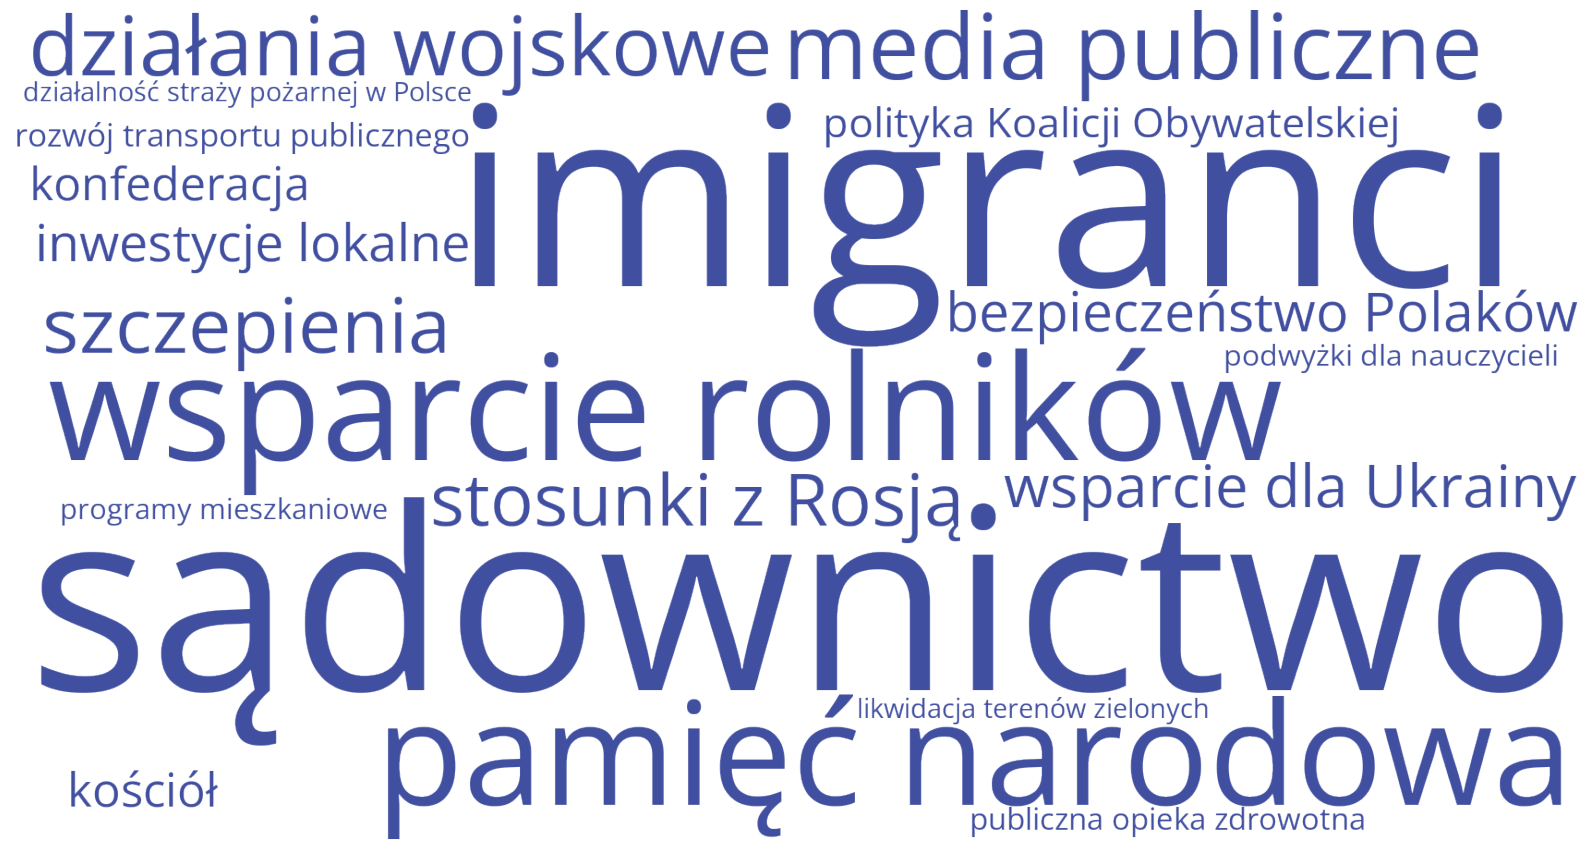

In [20]:
wc = WordCloud(width=1700, height=900, background_color="rgba(255, 255, 255, 0)", mode="RGBA", prefer_horizontal=1, font_path = 'fonts/Open_Sans/static/OpenSans-Regular.ttf')

image = wc.generate_from_frequencies(
df_filtered['topic_name'].value_counts().head(20).to_dict()

)

fig, ax = plt.subplots()
ax.imshow( image.recolor(random_state=1, color_func=blue_color_func), interpolation='bilinear')
ax.axis('off')
fig.set_size_inches(16, 9)
fig.tight_layout()
fig.show()
plt.savefig("wc_tweets_os.svg")